# Modelling

The main objectives for this notebook are:
* To develop a model that will satisfiy our modelling objective
* To properly evaluate the developed model
* To have a trained model ready for deployment


## good things to do
1. Have a proper baseline
2. Perform post-modellign steps - threshold selection, explainability, false positives / false negatives
3. Use MLFlow for experiment tracking
4. Build an ML training pipeline using Kedro/ZenML/Metaflow/etc


In [1]:
import os
import sys
import warnings

import joblib
import mlflow
import numpy as np
import plotly.express as px
import polars as pl
import shap
from optuna.integration.mlflow import MLflowCallback
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split

In [2]:
# Path needs to be added manually to read from another folder
path2add = os.path.normpath(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), os.path.pardir, "utils"))
)
if  (path2add not in sys.path):
    sys.path.append(path2add)

from ml_util_funcs import evaluate_thresholds, tune_hgbt

In [3]:
warnings.filterwarnings("ignore")
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("api_anomaly")
mlflow.sklearn.autolog(disable=True)

## Read Data

In [4]:
data = pl.read_parquet('../data/supervised_clean_data_w_features.parquet')
data.sample(3)

,_id,inter_api_access_duration(sec),api_access_uniqueness,sequence_length(count),vsession_duration(min),ip_type,num_sessions,num_users,num_unique_apis,source,classification,is_anomaly,max_global_source_degrees,avg_global_source_degrees,min_global_dest_degrees,std_local_source_degrees,max_global_dest_degrees,min_global_source_degrees,std_global_source_degrees,n_connections,avg_global_dest_degrees
i64,str,f64,f64,f64,i64,str,f64,f64,f64,str,str,bool,u32,f64,u32,f64,u32,u32,f64,u32,f64
264,"""54619a66-49c6-3b20-ad0c-5d28d9…",0.000707,0.006075,17.447005,161,"""default""",307.0,217.0,23.0,"""E""","""normal""",false,32071,5608.6875,147,2.448899,22416,188,9217.077236,112,4725.723214
760,"""dfa7fdcd-aa09-31e5-80ac-d1d11d…",0.001211,0.018717,11.359813,354,"""default""",586.0,428.0,91.0,"""E""","""normal""",false,32071,6797.56044,65,6.5931,22416,79,8604.982975,273,8335.622711
649,"""1208e47e-3aca-37ba-936c-e088d8…",0.007887,0.020075,74.945946,3937,"""default""",128.0,111.0,167.0,"""E""","""normal""",false,32071,4713.2257,3,11.024377,22416,3,7851.586129,607,5355.265239


## Data Processing for Modelling

Doing initial modelling, I've noticed that we can perfectly prdict outliers using the provided features which is not surprising - it's generally quite easy to replicate the results of unsupervised models in a supervised way. Hence, the modelling goal for this project has shifted from <br><br> `To develop a supervised model to classify behaviour into normal and anomalous` <br><br> to <br><br>`To develop a supervised model using the engineered features to classify behaviour into normal and anomalous` 

In [5]:
label = "is_anomaly"
numerical_features = [
    "max_global_source_degrees",
    "avg_global_source_degrees",
    "min_global_dest_degrees",
    "std_local_source_degrees",
    "max_global_dest_degrees",
    "min_global_source_degrees",
    "std_global_source_degrees",
    "n_connections",
    "avg_global_dest_degrees",
]

data = data.filter(pl.col('ip_type') == 'default').select([label] + numerical_features) # 
data.sample(3)

is_anomaly,max_global_source_degrees,avg_global_source_degrees,min_global_dest_degrees,std_local_source_degrees,max_global_dest_degrees,min_global_source_degrees,std_global_source_degrees,n_connections,avg_global_dest_degrees
bool,u32,f64,u32,f64,u32,u32,f64,u32,f64
false,596,233.272727,6,1.636657,1151,10,188.743503,44,493.136364
true,32071,16747.5,1023,0.0,1217,1424,21670.701523,2,1120.0
false,32071,4676.90776,9,21.768394,22416,8,7840.658391,1366,5066.058565


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[numerical_features], data[label].to_list(), test_size=0.2)

[UInt32, Float64, UInt32, Float64, UInt32, UInt32, Float64, UInt32, Float64]
[False, True, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, True, True, False, False, True, True, False, True, True, False, True, False, False, True, False, True, False, True, False, False, False, False, True, True, False, True, False, True, True, False, False, False, True, False, False, True, False, False, False, True, False, True, True, False, False, False, False, False, True, False, False, True, False, False, False, False, False, False, False, True, False, False, False, False, False, True, False, False, False, True, False, False, False, False, True, False, False, False, True, False, True, False, False, False, True, True, True, False, True, False, False, False, True, True, False, False, True, False, True, False, False, True, False, False, False, False, False, True, True, True, True, False, False, True, T

In [7]:
print("Train shape: ", X_train.shape)
print("Test shape::", X_test.shape)

Train shape:  (1233, 9)
Test shape:: (309, 9)


## Baseline
Before building a model, we need to understand whether the problem can be solved without using ML. 

In [8]:
from sklearn.metrics import f1_score

heuristic_f1_scores = []
possible_values = X_train['n_connections'].sort().unique().to_list()
for v in possible_values:
    heuristic_pred = X_test.select(pl.col('n_connections') <= v).to_pandas()
    heuristic_f1_scores.append(f1_score(y_test, heuristic_pred))

In [9]:
px.line(
    x=possible_values, 
    y=heuristic_f1_scores, 
    labels={
        "x": "Number of Connections Threshold",
        "y": "F1 Score",
    },
    title='F1 Score for Heuristic Rule'
)

**Insights**
* The optimal number of connections to set as threshold is 46
* Heuristic rule can achive the F1 score of 0.73

## Machine Learning

### Base Model

In [10]:
with mlflow.start_run(run_name='GBT_baseline'):
    params = {
        "learning_rate": 0.1,
        "max_iter": 100,
        "max_leaf_nodes": 31,
        "max_depth": None,
        "l2_regularization": 0,
    }

    mlflow.set_tag("model_name", "HGBT")
    mlflow.log_params(params)

    gbt = HistGradientBoostingClassifier(**params)
    
    roc_auc = cross_val_score(gbt, X_train, y_train, cv=5, scoring='roc_auc').mean()
    print('ROC AUC (avg 5-fold):', roc_auc)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.sklearn.log_model(gbt, "gbt_models")

  File "c:\Users\larib\Projects\Api security\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


ROC AUC (avg 5-fold): 0.9862419528983061


2024/11/06 10:35:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


**Observations**
* The ROC AUC achieved by the baseline model has very high ROC AUC score of 0.99

**Insights**
* This indicates either target leakage or that the task is very simple
* Given that we don't know how the target was created, we can assume that the data set creates have used some simple anomaly detection methods

**Impact**
* We don't need to do hyperparameter tuning because the task is too simple

### Tuned Model

In [11]:
mlflc = MLflowCallback(
    tracking_uri="sqlite:///mlflow.db",
    metric_name="roc auc",
)

best_trial = tune_hgbt(20, mlflc, X_train, y_train)

[I 2024-11-06 10:35:32,395] A new study created in memory with name: hgbt_tuning
[I 2024-11-06 10:35:33,026] Trial 0 finished with value: 0.9847410806447179 and parameters: {'max_iter': 59, 'max_leaf_nodes': 29, 'max_depth': 6, 'l2_regularization': 2.746259734835008}. Best is trial 0 with value: 0.9847410806447179.


ROC AUC (avg 5-fold): 0.9847410806447179


[I 2024-11-06 10:35:33,346] Trial 1 finished with value: 0.9762018923404139 and parameters: {'max_iter': 95, 'max_leaf_nodes': 17, 'max_depth': 2, 'l2_regularization': 2.9939167492848897}. Best is trial 0 with value: 0.9847410806447179.


ROC AUC (avg 5-fold): 0.9762018923404139


[I 2024-11-06 10:35:33,543] Trial 2 finished with value: 0.9766545275959542 and parameters: {'max_iter': 18, 'max_leaf_nodes': 14, 'max_depth': 5, 'l2_regularization': 2.092480148312533}. Best is trial 0 with value: 0.9847410806447179.


ROC AUC (avg 5-fold): 0.9766545275959542


[I 2024-11-06 10:35:34,533] Trial 3 finished with value: 0.9852046046991724 and parameters: {'max_iter': 90, 'max_leaf_nodes': 24, 'max_depth': 10, 'l2_regularization': 7.559981031890977}. Best is trial 3 with value: 0.9852046046991724.


ROC AUC (avg 5-fold): 0.9852046046991724


[I 2024-11-06 10:35:34,947] Trial 4 finished with value: 0.9846114710094398 and parameters: {'max_iter': 50, 'max_leaf_nodes': 26, 'max_depth': 5, 'l2_regularization': 0.7239202838308656}. Best is trial 3 with value: 0.9852046046991724.


ROC AUC (avg 5-fold): 0.9846114710094398


[I 2024-11-06 10:35:35,716] Trial 5 finished with value: 0.9865544846080982 and parameters: {'max_iter': 91, 'max_leaf_nodes': 21, 'max_depth': 10, 'l2_regularization': 0.4361615552495446}. Best is trial 5 with value: 0.9865544846080982.


ROC AUC (avg 5-fold): 0.9865544846080982


[I 2024-11-06 10:35:36,066] Trial 6 finished with value: 0.9852994254123211 and parameters: {'max_iter': 46, 'max_leaf_nodes': 30, 'max_depth': 10, 'l2_regularization': 1.8385577556255195}. Best is trial 5 with value: 0.9865544846080982.


ROC AUC (avg 5-fold): 0.9852994254123211


[I 2024-11-06 10:35:36,310] Trial 7 finished with value: 0.9766286242886386 and parameters: {'max_iter': 100, 'max_leaf_nodes': 22, 'max_depth': 2, 'l2_regularization': 3.7544324047525457}. Best is trial 5 with value: 0.9865544846080982.


ROC AUC (avg 5-fold): 0.9766286242886386


[I 2024-11-06 10:35:36,978] Trial 8 finished with value: 0.9859810915916254 and parameters: {'max_iter': 76, 'max_leaf_nodes': 26, 'max_depth': 8, 'l2_regularization': 2.8154244440580523}. Best is trial 5 with value: 0.9865544846080982.
[I 2024-11-06 10:35:37,118] Trial 9 finished with value: 0.9500234352545405 and parameters: {'max_iter': 36, 'max_leaf_nodes': 17, 'max_depth': 2, 'l2_regularization': 5.64531782197851}. Best is trial 5 with value: 0.9865544846080982.


ROC AUC (avg 5-fold): 0.9859810915916254
ROC AUC (avg 5-fold): 0.9500234352545405


[I 2024-11-06 10:35:37,534] Trial 10 finished with value: 0.9837172011406778 and parameters: {'max_iter': 72, 'max_leaf_nodes': 12, 'max_depth': 8, 'l2_regularization': 9.760291226492932}. Best is trial 5 with value: 0.9865544846080982.


ROC AUC (avg 5-fold): 0.9837172011406778


[I 2024-11-06 10:35:38,101] Trial 11 finished with value: 0.986939073461747 and parameters: {'max_iter': 75, 'max_leaf_nodes': 20, 'max_depth': 8, 'l2_regularization': 0.26721356352126024}. Best is trial 11 with value: 0.986939073461747.


ROC AUC (avg 5-fold): 0.986939073461747


[I 2024-11-06 10:35:38,731] Trial 12 finished with value: 0.9864066726149863 and parameters: {'max_iter': 78, 'max_leaf_nodes': 19, 'max_depth': 8, 'l2_regularization': 0.0523902089156158}. Best is trial 11 with value: 0.986939073461747.


ROC AUC (avg 5-fold): 0.9864066726149863


[I 2024-11-06 10:35:39,411] Trial 13 finished with value: 0.9848409836721126 and parameters: {'max_iter': 66, 'max_leaf_nodes': 21, 'max_depth': 9, 'l2_regularization': 4.8163871358703085}. Best is trial 11 with value: 0.986939073461747.


ROC AUC (avg 5-fold): 0.9848409836721126


[I 2024-11-06 10:35:40,496] Trial 14 finished with value: 0.9872105930074755 and parameters: {'max_iter': 86, 'max_leaf_nodes': 18, 'max_depth': 7, 'l2_regularization': 0.6673268390658417}. Best is trial 14 with value: 0.9872105930074755.


ROC AUC (avg 5-fold): 0.9872105930074755


[I 2024-11-06 10:35:41,140] Trial 15 finished with value: 0.9860486162659049 and parameters: {'max_iter': 84, 'max_leaf_nodes': 15, 'max_depth': 7, 'l2_regularization': 1.1616927357982687}. Best is trial 14 with value: 0.9872105930074755.


ROC AUC (avg 5-fold): 0.9860486162659049


[I 2024-11-06 10:35:41,437] Trial 16 finished with value: 0.9836869134469512 and parameters: {'max_iter': 62, 'max_leaf_nodes': 10, 'max_depth': 6, 'l2_regularization': 6.352969558257753}. Best is trial 14 with value: 0.9872105930074755.


ROC AUC (avg 5-fold): 0.9836869134469512


[I 2024-11-06 10:35:41,795] Trial 17 finished with value: 0.9809482696138341 and parameters: {'max_iter': 38, 'max_leaf_nodes': 19, 'max_depth': 4, 'l2_regularization': 4.121987677653215}. Best is trial 14 with value: 0.9872105930074755.


ROC AUC (avg 5-fold): 0.9809482696138341


[I 2024-11-06 10:35:42,529] Trial 18 finished with value: 0.986192764294087 and parameters: {'max_iter': 82, 'max_leaf_nodes': 24, 'max_depth': 7, 'l2_regularization': 1.4729576654729453}. Best is trial 14 with value: 0.9872105930074755.


ROC AUC (avg 5-fold): 0.986192764294087


[I 2024-11-06 10:35:43,065] Trial 19 finished with value: 0.9842659248762224 and parameters: {'max_iter': 72, 'max_leaf_nodes': 16, 'max_depth': 7, 'l2_regularization': 7.94097694373105}. Best is trial 14 with value: 0.9872105930074755.


ROC AUC (avg 5-fold): 0.9842659248762224


In [12]:
print(best_trial.params)

{'max_iter': 86, 'max_leaf_nodes': 18, 'max_depth': 7, 'l2_regularization': 0.6673268390658417}


### The Final Model

In [ ]:
best_gbt = HistGradientBoostingClassifier(**best_trial.params)
best_gbt.fit(X_train, y_train)
test_preds = best_gbt.predict_proba(X_test)

print('Test ROC AUC:', roc_auc_score(y_test, test_preds[:, 1]))
print('Test PR AUC:', average_precision_score(y_test, test_preds[:, 1]))

(32071, 6617.460526315789, 13, 2.5564503899921913, 22013, 15, 9737.999995126707, 76, 5742.868421052632)
shape: (309, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ max_globa ┆ avg_globa ┆ min_globa ┆ std_local ┆ … ┆ min_globa ┆ std_globa ┆ n_connect ┆ avg_glob │
│ l_source_ ┆ l_source_ ┆ l_dest_de ┆ _source_d ┆   ┆ l_source_ ┆ l_source_ ┆ ions      ┆ al_dest_ │
│ degrees   ┆ degrees   ┆ grees     ┆ egrees    ┆   ┆ degrees   ┆ degrees   ┆ ---       ┆ degrees  │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ u32       ┆ ---      │
│ u32       ┆ f64       ┆ u32       ┆ f64       ┆   ┆ u32       ┆ f64       ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 32071     ┆ 6889.6967 ┆ 56        ┆ 8.401132  ┆ … ┆ 84        ┆ 8194.2978 ┆ 366       ┆ 7499.306 │
│           ┆ 21        ┆           ┆           ┆   ┆           ┆ 44    

## Threshold Analysis & Evaluation

In [14]:
thresholds = np.arange(0, 1.01, 0.01)

rcs, prs, f1s = evaluate_thresholds(thresholds, y_test, test_preds, plot=True)

Threshold with Max F1 Score:  0.63
F1 at threshold 0.63: 0.9536423841059603
Recall at threshold 0.63: 0.96
Precision at threshold 0.63: 0.9473684210526315 


## Model Diagnostics

#### Feature Importances

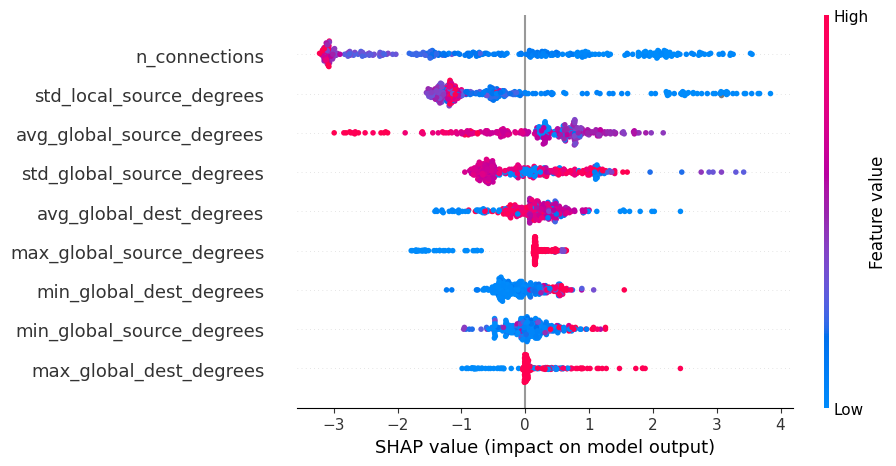

In [15]:
explainer = shap.Explainer(best_gbt)
shap_values = explainer(X_test[numerical_features].to_pandas())
shap.plots.beeswarm(shap_values)

#### False Positives & False Negatives

In [16]:
thr = 0.24
test_binary_pred = test_preds[:, 1] >= thr

fps = np.where((np.array(y_test) == False) & (test_binary_pred == True))[0]
fns = np.where((np.array(y_test) == True) & (test_binary_pred == False))[0]

print(f"There are {len(fps)} false positives")
print(f"There are {len(fns)} false negatives")

There are 17 false positives
There are 1 false negatives


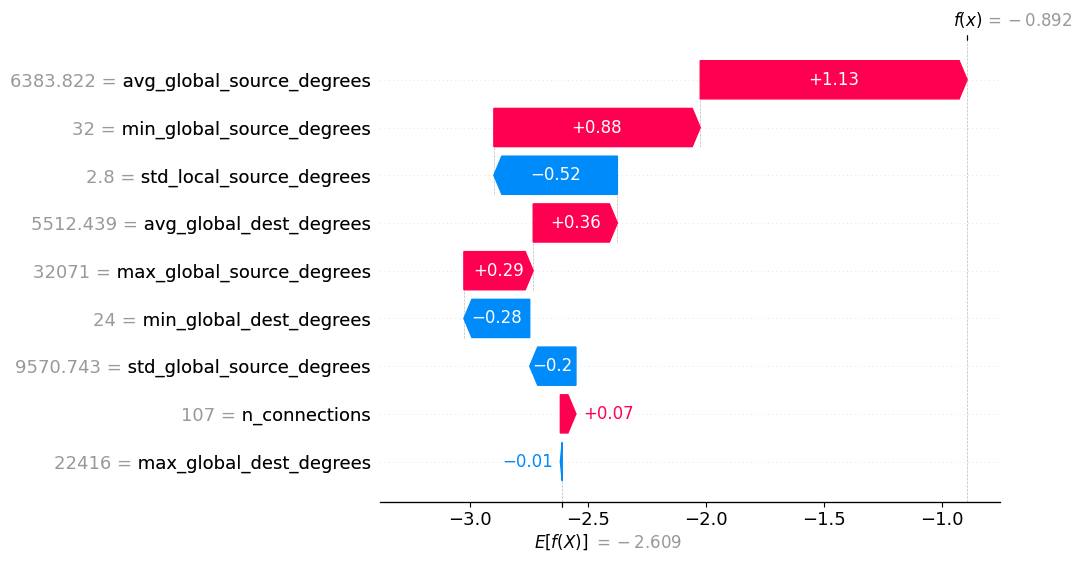

In [17]:
shap.plots.waterfall(shap_values[fps[0]])

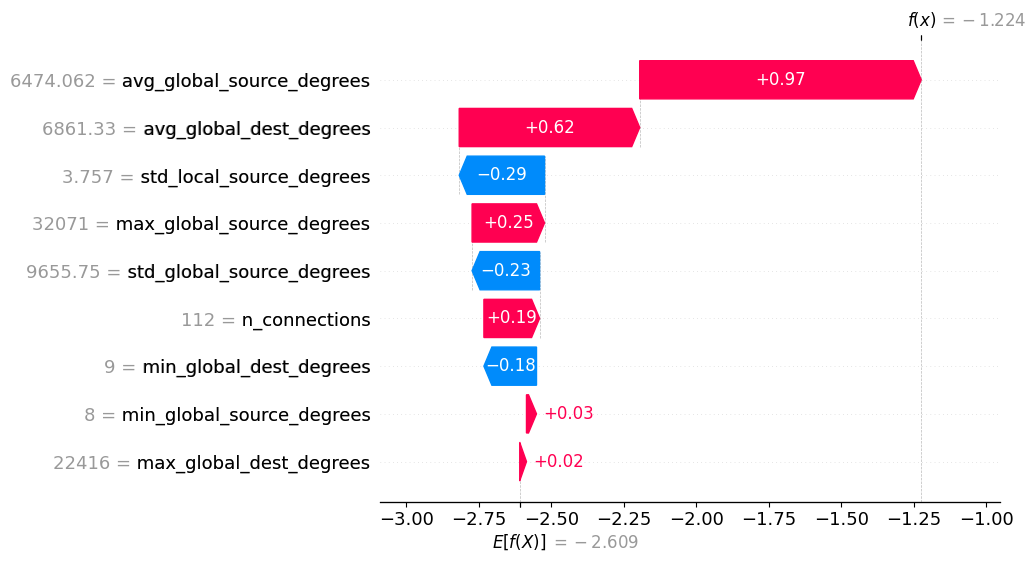

In [18]:
shap.plots.waterfall(shap_values[fns[0]])

## Save Model for Deployment

In [19]:
joblib.dump(best_gbt, '../models/hgbt_final.joblib')

['../models/hgbt_final.joblib']

## Summary

* The modelling task for anomaly detection is quite easily solved by training supervised ML model
* To make the task more challenging, only the engineered features were used to identify the anomalies
* The optimal model that was trained is HistGBT with threshold of 0.24
* The maximum F1 that can be achieved with the trained model is 0.92, which gives us a recall of 0.95 and precision 0.90
* The trained model outperforms heuristic baseline by 0.20 in terms of F1 score
* SHAP values suggest that smaller networks tend to be more anomalous